## Install

```
pip install qsample
```

## Prerequisites 

* python3  
* pdflatex (for circuit rendering)  

## When to use

* For QEC protocols with in-sequence measurements and feed-forward of measurement information
* Apply circuit-level incoherent Pauli noise at low physical error rates (i.e. high fidelity physical operations)
* Simulate and sample protocol execution over ranges of varying physical error rates, using customizable callbacks

## Getting started

In [ ]:
import qsample as qs
import matplotlib.pyplot as plt  # for visualization of results

First, we need to define a quantum protocol of which we would like to know the logical error rate. In `qsample` a protocol is represented as a graph of quantum `Circuits` as nodes and boolean transition `checks` between them. Each `check` is evaluated at runtime to determined the next circuit to choose, thus simulation of non-deterministic protocols is possible.

As an example, let's sample the logical error rates of an error-corrected quantum state teleportation protocol. We define the teleportation circuit `teleport` which sends the state the first qubit is in, here $|0\rangle$, to the third qubit.

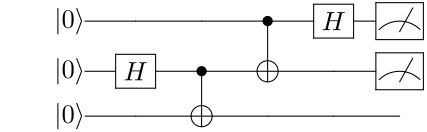

In [ ]:
teleport = qs.Circuit([{"init": {0, 1, 2}},
                       {"H": {1}},
                       {"CNOT": {(1, 2)}},
                       {"CNOT": {(0, 1)}},
                       {"H": {0}},
                       {"measure": {0, 1}}])

teleport.draw()

Additionally, we need a circuit to (perfectly) measure the third qubit after running `teleport` to verify if the teleportation was successful. If the outcome of this measurement is 0 (corresponding to the initially prepared $|0\rangle$ state of qubit 1) the teleportation succeded. If the outcome is 1 it (logically) failed, we thus want to increment a logical fail counter. Let's create a circuit for this measurement and let's assume we can perform this measurement without noise.

In [ ]:
meas = qs.Circuit([{"measure": {2}}], noisy=True)

Between the `teleport` and `meas` circuits apply a correction to qubit 3 conditioned on the measurement outcome (syndrome) of the teleportation circuit. We define the lookup function `lut` as follows

In [ ]:
def lut(syn):
    op = {0: 'I', 1: 'X', 2: 'Z', 3: 'Y'}[syn]
    return qs.Circuit([{op: {2}}], noisy=False)

Finally, define the circuit sequence and transition logic together within a `Protocol` object. Note that protocols must always commence with a unique *START* node and terminate at a (not necessarily unique) *FAIL* node, where the latter expresses a logical failure event.

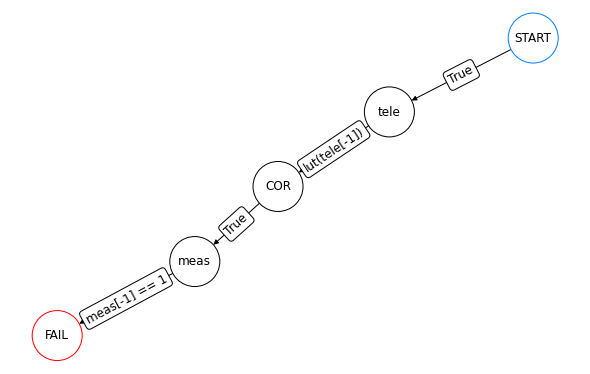

In [ ]:
tele_proto = qs.Protocol(check_functions={'lut': lut})
tele_proto.add_nodes_from(['tele', 'meas'], circuits=[teleport, meas])
tele_proto.add_edge('START', 'tele', check='True')
tele_proto.add_edge('tele', 'COR', check='lut(tele[-1])')
tele_proto.add_edge('COR', 'meas', check='True')
tele_proto.add_edge('meas', 'FAIL', check='meas[-1] == 1')

tele_proto.draw(figsize=(8,5))

Notice that we do not define any initial circuit for the correction *COR* but pass our lookup function to the `check_functions` dictionary, which makes it accessible inside the `check` transition statements between circuits. This way we can also dynamically inject correction circuits into the protocol at execution time.

After the protocol has been defined we can repeatedly execute (i.e. sample) it in the presence of incoherent noise. Let's say we are interested in the logical error rates of all 1- and 2-qubit gates and measurements subject to physical errors with physical error rates $p_{phy}=10^{-5}, \dots, 10^{-1}$, and $0.5$. The corresponding noise model is called `E1_1` in qsample. The groups of all 1- and 2-qubit gates are indexed by the key *q* in `E1_1`. Other noise models (and their parameters) are described in the documentation.

In [ ]:
err_model = qs.noise.E1_1
err_params = {'q': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]}

We are ready to sample. As our protocol only contains Clifford gates let's choose the `StabilizerSimulator`, as well as the `PlotStats` callback for plotting the resulting logical error rate as function of our chosen $p_{phy}$. For now, let's use our *inefficient* sampler, `DirectSampler`, which executes `n_shots` naive Monte Carlo samples at each physical error rate.

p=('1.00e-05',):   0%|          | 0/20000 [00:00<?, ?it/s]

p=('1.00e-04',):   0%|          | 0/20000 [00:00<?, ?it/s]

p=('1.00e-03',):   0%|          | 0/20000 [00:00<?, ?it/s]

p=('1.00e-02',):   0%|          | 0/20000 [00:00<?, ?it/s]

p=('1.00e-01',):   0%|          | 0/20000 [00:00<?, ?it/s]

p=('5.00e-01',):   0%|          | 0/20000 [00:00<?, ?it/s]

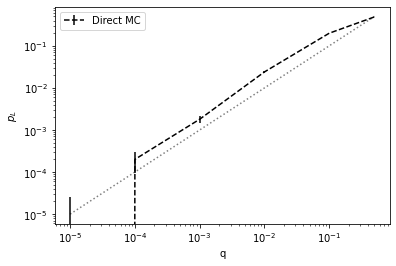

In [ ]:
sam = qs.DirectSampler(protocol=tele_proto, simulator=qs.StabilizerSimulator, err_model=err_model, err_params=err_params)
sam.run(n_shots=20000, callbacks=[qs.callbacks.PlotStats()])

Notice, that at low error rates `DirectSampler` performs badly, i.e. the error bars become very large, as most of the time the protocol is executed error free and, consequently, logical errors are measured infrequently. In this regime it is much more efficient to use an importance sampling strategy to avoid fault-free protocol execution and instead put more emphasis on execution with at least one physical error, i.e. *fault*, happening. This approach is implemented in the `SubsetSampler` class. We only need to specify **two additional parameters**: `p_max` which specifies the $p_{phy}$ at which sampling takes place, and `L`, the length of the longest possible fault-free path. We choose the parameter `p_max` experimentally by repeated sampling and observing which subsets have the largest impact on the failure rate. We always choose a value such that the subset occurence probability has an exponentially falling shape. Below we see that for the teleportation circuit `p_max`-values of 0.01 and 0.1 are still okay, while 0.3 could be problematic. For more information refer to the linked publication.

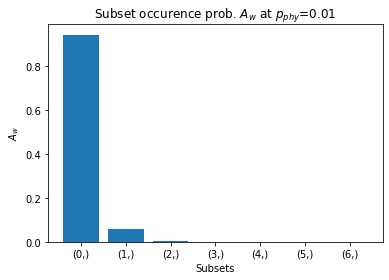

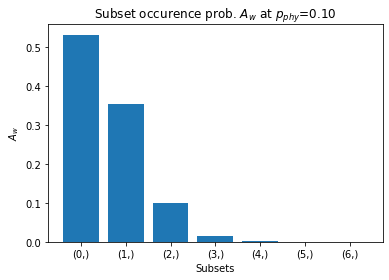

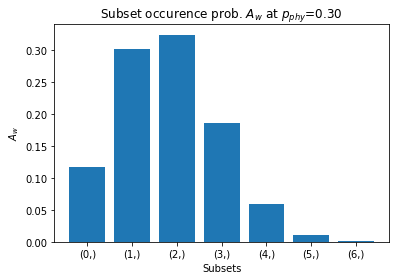

In [ ]:
for p_phy in [0.01, 0.1, 0.3]:
    Aws = qs.math.subset_probs(teleport, err_model(), p_phy)
    plt.figure()
    plt.title("Subset occurence prob. $A_w$ at $p_{phy}$=%.2f" % p_phy)
    plt.bar(list(map(str,Aws.keys())), Aws.values())
    plt.ylabel("$A_w$")
    plt.xlabel("Subsets")

Let's choose a $p_{max}=0.1$ for the same error model as before and start sampling. (Note the significant difference in the number of samples). 

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

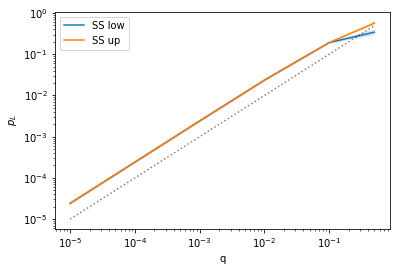

In [ ]:
ss_sam = qs.SubsetSampler(protocol=tele_proto, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000, callbacks=[qs.callbacks.PlotStats()])

The sampling results are internally stored by the `SubsetSampler` in a `Tree` data structure. In the tree we can also see why we chose `L`=3, as there are three circuits in the fault-free path sequence. 

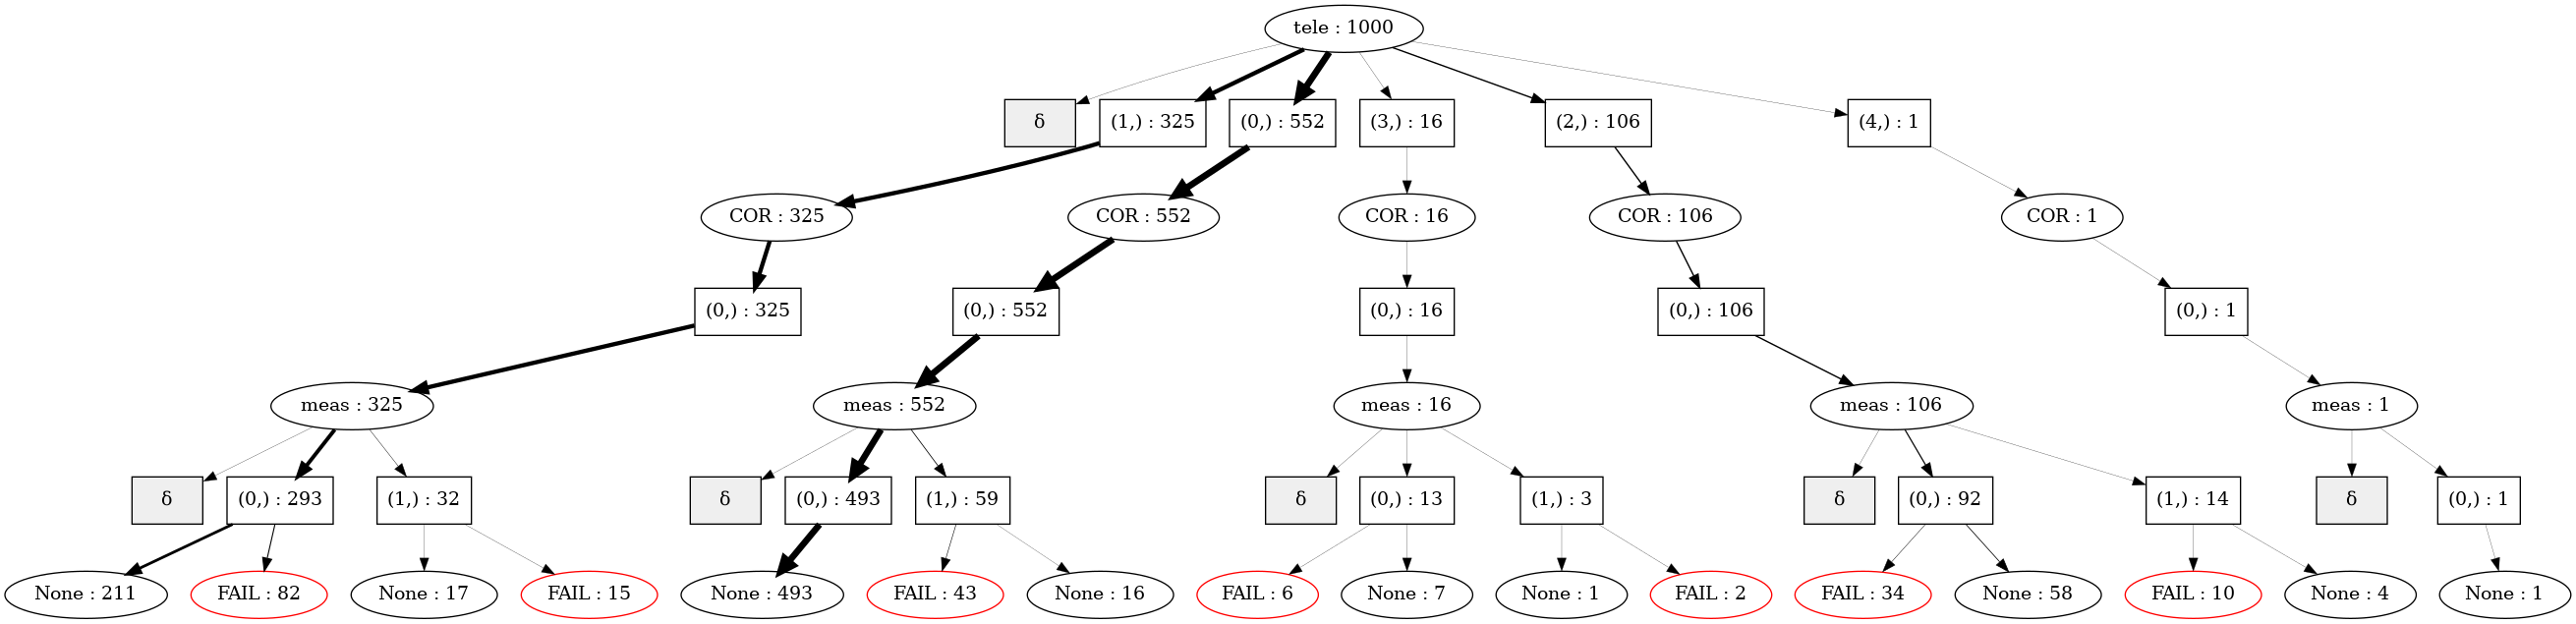

In [ ]:
ss_sam.tree.draw(verbose=True)

We see that only the teleportation protocol has fault weight subsets, while the *meas* and *COR* circuits are noise-free (i.e. they only have the 0-subset). The leaf nodes *FAIL* and *None* represent logical failure and successful teleportation events, respectively. $\delta$ represents the missing subsets which have not been sampled and which result in the upper bound on the failure rate.

Finally, let's compare the results of `DirectSampler` and `SubsetSampler`.

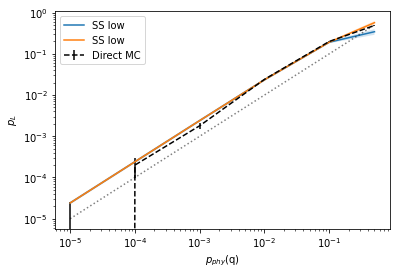

In [ ]:
p_L_low, std_low, p_L_up, std_up = ss_sam.stats()
p_L, std = sam.stats()

sample_range = err_params['q']
plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.loglog(sample_range, p_L_low, label='SS low')
plt.fill_between(sample_range, p_L_low - std_low, p_L_low + std_low, alpha=0.2)
plt.loglog(sample_range, p_L_up, label='SS low')
plt.fill_between(sample_range, p_L_up - std_up, p_L_up + std_up, alpha=0.2)
plt.plot(sample_range, sample_range,'k:', alpha=0.5)
plt.xlabel('$p_{phy}$(q)')
plt.ylabel('$p_L$')
plt.legend();

## More things to explore

* `qsample.examples` shows more examples of protocol and protocol samplings.
* `qsample.noise` defines more complex error models, as well as a superclass `ErrorModel` which can be used to define custom error models.
* `qsample.callbacks` defines more callbacks, as well as the superclass `Callback` which allows for the implementation of custom callbacks.

## Contribute 

* Feel free to submit your feature request via github issues

## Cite as

```
@misc{qsample,
    author = {Winter, Don and Heu{\ss}en, Sascha},
    title = {qsample},
    year = {2023},
    publisher = {GitHub},
    journal = {GitHub repository},
    howpublished = {\url{https://github.com/dpwinter/qsample}}
}
```

## Team 

`qsample` was developed by Don Winter in collaboration with Sascha Heußen under supervision of Manuel Rispler and Markus Müller.